In [1]:
import numpy as np
from skimage import data, io, util, transform, filters, color
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage import feature
import os
data_dir = "C:\\Users\\aramacha\\AnacondaProjects\\CS376\\AssignWriteups"
print (data_dir)

C:\Users\aramacha\AnacondaProjects\CS376\AssignWriteups


### 1. Describe a possible flaw in the use of additive Gaussian noise to represent image noise.

Gaussian filter acts as a low-pass filter and thus doesn't represent the noise in higher frequency domains.  So, the noise distribution is not uniform, like that of a box-filter.

### 2 The filter , f' =[0, -0.5, 0, 0.5, 0] gives an estimate of the first derivative of the image in the x direction. What is the corresponding second derivative filter f ′′ ? (Hint: asymmetric filters must be flipped prior to convolution.)

f'' = [f'(x+1) - f(x-1)]/1
```
f''[0] = [-0.5 - 0]  = -0.5
f''[1] = [0 + 0.5] = 0.5
f''[2] = [0.5 - 0] = 0.5
f''[3] = [0 - 0.5] = -0.5
f''[4] = [0 - 0] = 0
```

**f'' = [-0.5 0.5 0.5 -0.5 0]**

### 3. Consider the filtr f = [1, 2, 1] and 1D image I = = [0,1,2,3,3,3,1,3,6]?  What is f * I?


In [2]:
f = np.array([1, 2, 1]) # with zero padding
I = np.array([0,1,2,3,3,3,1,3,6])
print (np.convolve(I,f, 'same'))

x0 = I[0]*f[0]
x1 = I[1]*f[0] + I[0]*f[1]
x2 = I[2]*f[0] + I[1]*f[1] + I[0]*  f[2]
x3 = I[3]*f[0] + I[2]*f[1] + I[1]*  f[2]
x4 = I[4]*f[0] + I[3]*f[1] + I[2]*  f[2]
x5 = I[5]*f[0] + I[4]*f[1] + I[3]*  f[2]
x6 = I[6]*f[0] + I[5]*f[1] + I[4]*  f[2]

print ((x0, x1, x2, x3, x4, x5 ,x6))

#Flip I and correlate
I = (I[::-1])
np.correlate (f, I.T)


[ 1  4  8 11 12 10  8 13 15]
(0, 1, 4, 8, 11, 12, 10)


array([ 4,  8, 11, 12, 10,  8, 13])

### 4. Name two specific ways in which one could reduce the amount of fine, detailed edges that are detected with the Canny edge detector. 

Avg. weighted filter and Gaussian Filters can be used to smoothen out and reduce the amount of detailed edges.

### 5. Design a method that takes video data from a camera perched above a conveyor belt on which
customers place their produce (apples, oranges, broccoli, etc), and automatically computes the
bill. Your response should be a list of concise, specific steps, and should incorporate at least two
techniques covered in class thus far. Specify any important assumptions your method makes.

1. Find the Shape of the produce by detecting the edges - Use Canny edge detector to find the edges. 
2. Shape Search (Chamfer distance algorithm): If a single match got to step 4, else if more than 2 matches go to Step 3.
2. Texture Search: Take the new image of the produce and perform 'Thresholding' to obtain a Binary Image.
3. Find the texture of the object and template match (with euclidean distance) the texture of the produce, if not detected, ask for 'human intervention'
4. Weigh the new produce.
5. Find the cost in $ = Weigh of the produce (in lbs) X $dollarperlbs[produce].

[[ 0.41723804  0.43934588  0.45473451 ...,  0.37151059  0.34854667
   0.32247176]
 [ 0.42423294  0.42141255  0.45081294 ...,  0.39612627  0.37340745
   0.34847137]
 [ 0.43352745  0.38616314  0.38026941 ...,  0.40148431  0.41798118
   0.35354667]
 ..., 
 [ 0.53496745  0.52598549  0.52262941 ...,  0.33977294  0.31788745
   0.34198235]
 [ 0.53409647  0.53381373  0.5301749  ...,  0.36638275  0.35770627
   0.31540235]
 [ 0.55065373  0.54281059  0.53553294 ...,  0.3829102   0.40027098
   0.36300471]]


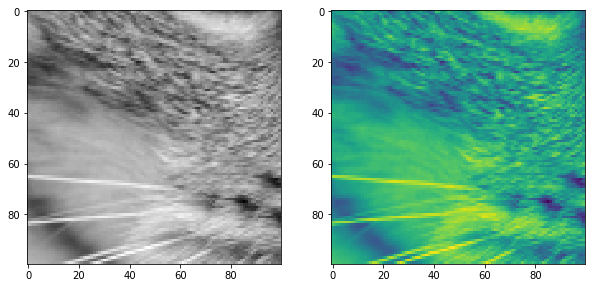

In [3]:
cat = data.chelsea()
cat = rgb2gray(cat)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 20))
#ax3 = plt.subplot(1, 3, 3)
cat = cat[150:250, 100:200]
ax0.imshow(cat, cmap='gray');
row, col = cat.shape
print (cat)
filename = os.path.join(data_dir, 'disney.jpg')

austin = io.imread(filename)
austin = rgb2gray(austin)
austin = cat
ax1.imshow(austin)
plt.show()

## Energy Function using Sobel Filter

In [11]:
def energyFunction(img, row=1, col=1, debugPrint = 0):
    img = rgb2gray(img)
    [row, col] = img.shape
    df_dx=np.ones((row, col), dtype=np.float64)
    df_dy=np.ones((row, col), dtype=np.float64)

    f = np.pad(img, (0,1), 'mean') #zero pad the right values
    if (debugPrint):    print (f.shape)
    for i in range(row):
        for j in range(col):
            df_dx[i, j] = (f[i, j+1] - f[i, j])
            #print (j, (f[0, j+1] - f[0, j]))
        
    for j in range(col):
        for i in range(row):
            df_dy[i, j] = (f[i+1, j] - f[i, j])
 
    df_dx = (np.square(df_dx))
    df_dy = (np.square(df_dy))
    energy = np.sqrt(df_dx + df_dy)
    
    energy = filters.sobel(img)

    return (energy)



In [5]:
def M_matrix(energy):
#M(i, j) = Energy(i, j) + min(M(i -1, j -1),M(i-1, j),M(i -1, j +1))
    rows, cols = energy.shape
    M = np.zeros(energy.shape, dtype=np.float64)
    for i in range(1,rows):
        for j in range(1, cols-1):
            M[i, j] = energy[i, j] + min(M[i-1, j-1], M[i-1, j], M[i-1, j+1])
    return(M)




In [10]:
def Optimal_verticalSeam(img_orig, num_seams_to_remove =1, debugPrint = 0):
    img_bkup = img_orig
    #img_orig = np.flipud(img_orig)
    img_carved_mark = np.copy(img_orig)

    img_carved_prev = np.copy(img_orig)
    #img = ((rgb2gray(img_carved_prev)))
    
    #Caculate Energy of the img
    energy = energyFunction(img_orig)
    plt.imshow((energy))
    plt.show()
    MAX_SEAMS_REMOVE = num_seams_to_remove
    num_seams = 0
    #Min Energy Matrix
    M = M_matrix(energy)
    #1. Find the min element on the last row
    #2. back trace to the upper row by finding the min of the adjacent 3 elements
    #print (M)
    plt.imshow((M))
    plt.show()
    while (num_seams < MAX_SEAMS_REMOVE):

        M_carved = []
        img_carved = []
        rows, cols = M.shape
        verticalSeam = np.zeros(rows, dtype = np.int32)
        #print (verticalSeam)
        #print (M.shape)
        col_min_idx = np.argmin(M[-1,:])
        #optimalVerticalSeam.append(last_row_min_idx)
        verticalSeam[-1] = col_min_idx
        M_carved.append(np.delete(M[-1,:], verticalSeam[-1]))
        img_carved.append(np.delete(img_carved_prev[-1,:,:], verticalSeam[-1], axis=0))

        for i in range(rows-2, -1, -1):
            subtract_value = False
            if ( verticalSeam[i+1] == 0):
                col_min_idx = np.argmin([M[i, col_min_idx], M[i, 1+col_min_idx]])
            elif ( verticalSeam[i+1] == cols-1):
                col_min_idx = np.argmin([M[i, col_min_idx], M[i, col_min_idx-1]])
                if (col_min_idx == 1):
                    subtract_value = True
            else:
                col_min_idx = np.argmin([M[i, col_min_idx], M[i, col_min_idx+1], M[i, col_min_idx-1]])
                if (col_min_idx == 2):
                    subtract_value = True
                    

            if (subtract_value):
                verticalSeam[i] = verticalSeam[i+1] - 1
            else:
                verticalSeam[i] = verticalSeam[i+1] + col_min_idx
            
            
            if (debugPrint): print (i, verticalSeam[i], subtract_value, col_min_idx, num_seams)
            col_min_idx = verticalSeam[i]
            
            img_carved_mark[i, (num_seams + verticalSeam[i]), :] = ([255, 0, 0])

            img_carved.append(np.delete(img_carved_prev[i,:,:], verticalSeam[i], axis=0))
            M_carved.append(np.delete(M[i,:], verticalSeam[i]))
            
        M_carved = np.copy(np.flipud(M_carved))
        M = np.copy(M_carved)
        img_carved_prev = np.copy(np.flipud(img_carved))
        num_seams += 1
        
    plt.title('Image with my implementation')
    plt.imshow((img_carved_mark))
    plt.show()

    plt.imshow((img_carved_prev))
    plt.show()
    
    out = transform.seam_carve(img_orig, energy, 'vertical', MAX_SEAMS_REMOVE)
    plt.figure()
    plt.title('Resized using Pythons Seam Carving function')
    plt.imshow(out)
    plt.show()
    return img_carved_prev
    #print (verticalSeam)


#Optimal_verticalSeam(M)
#Optimal_horizontalSeam(M)

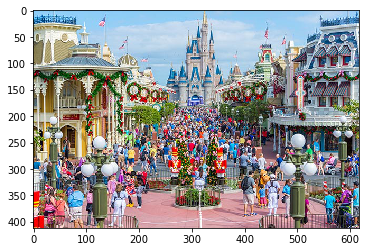

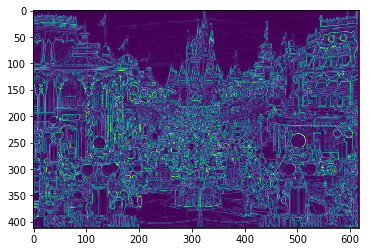

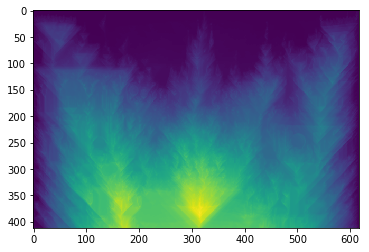

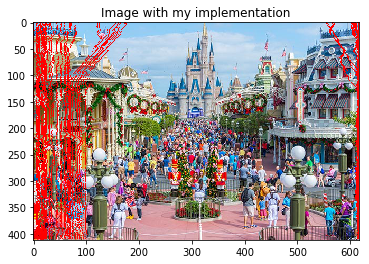

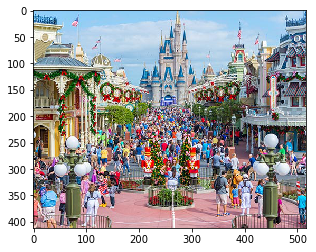

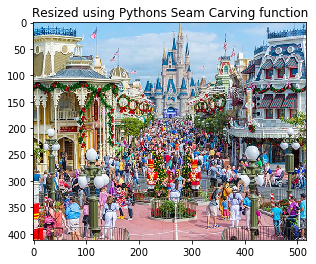

In [12]:

filename = os.path.join(data_dir, 'disney.jpg')
img = io.imread(filename)
#img = data.astronaut()

plt.imshow(img)
plt.show()

OutputImg = Optimal_verticalSeam(img, 100)



In [8]:
def Optimal_horizontalSeam(img, num_seams=1):

    img = np.swapaxes(img, 0, 1)
    #energy_map = np.swapaxes(energy_map, 0, 1)
    OutputImg = Optimal_verticalSeam(img, num_seams)
    #img = np.swapaxes(OutputImg,  1, 0)
    #OutputImg1 = Optimal_verticalSeam(np.rot90(img, k=1, axes=(1,0)), 100)
    OutputImg1 = np.swapaxes(OutputImg, 0, 1)
    plt.imshow(OutputImg1)
    plt.show()

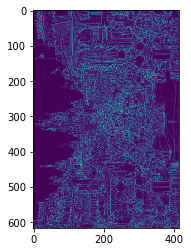

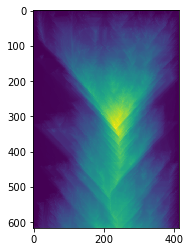

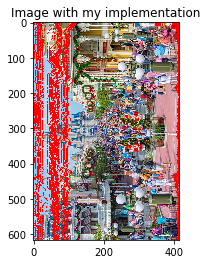

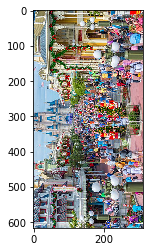

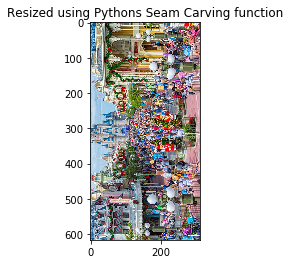

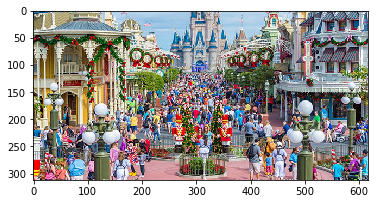

In [9]:
OutputImg = Optimal_horizontalSeam(img, 100)
